In [1]:
import pandas as pd
import numpy as np
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

from task_geo.data_sources.covid import cds
from task_geo.data_sources import get_data_source
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
all_data = get_data_source('cds')()
all_data.groupby('sub_region')['cases'].count().sort_values(ascending=False)


/home/wwymak/anaconda3/envs/immo-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


sub_region
Washington County     1593
Jefferson County      1149
Franklin County       1072
Jackson County         948
Lincoln County         916
                      ... 
Reeves County            1
Conejos County           1
Shackelford County       1
Stillwater County        1
Kingsbury County         1
Name: cases, Length: 2052, dtype: int64

In [3]:
washington = all_data[( all_data.region=='Washington') & (all_data["aggregate"] =='state')].reset_index(drop=True)
washington['date'] = washington.date.dt.normalize()
washington['day_of_week'] = washington.date.dt.dayofweek
washington.head()

,country,region,sub_region,city,lat,long,date,url,aggregate,tz,cases,deaths,recovered,active,tested,growth_factor,day_of_week
0,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-22,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,2
1,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-23,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,3
2,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-24,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,4
3,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-25,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,5
4,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-26,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,6


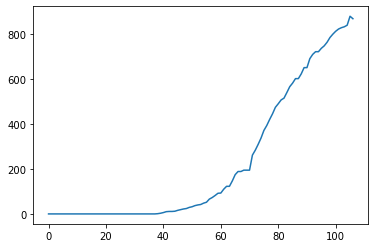

In [4]:
washington.deaths.plot()

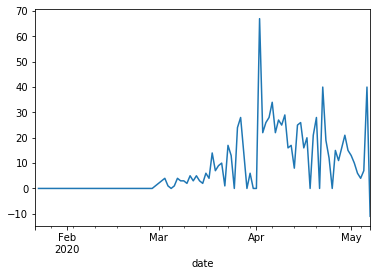

In [5]:
# if you want to look at the cumsum
# although, actually less sure about these...
washington['new_cases'] = washington.cases.diff()
washington['new_deaths'] = washington.deaths.diff()
washington['new_recoverd'] = washington.recovered.diff()
washington['new_tested'] = washington.tested.diff()

washington.set_index('date')['new_deaths'].plot()

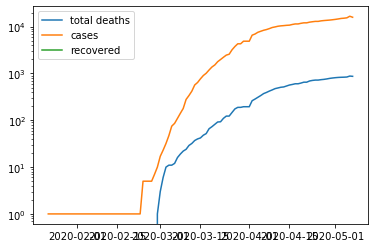

In [6]:
plt.plot(washington.date, washington['deaths'], label='total deaths');
plt.plot(washington.date, washington['cases'], label='cases');
plt.plot(washington.date, washington['recovered'], label='recovered');
plt.yscale('log');
plt.legend();

In [7]:
# mobility = get_data_source('mobility')()
# mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', parse_dates=['date'])
mobility  = get_data_source('mobility')()

/home/wwymak/anaconda3/envs/immo-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
washington_mobility = mobility[(mobility.country_iso=='US') & (mobility.region=='Washington') & mobility.sub_region.isna()].copy()
washington_mobility = washington_mobility.rename(columns={ k: f"mobility_{k}" for k in 
   [ "retail_recreation", "grocery_pharmacy", "parks", 
    "transit_stations",	"workplaces", "residential"]
})
washington_mobility.shape, washington_mobility.date.unique().shape

((78, 11), (78,))

In [9]:
washington_mobility

,country_iso,country,region,sub_region,date,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
292301,US,United States,Washington,NaN,2020-02-15,2.0,-1.0,8.0,8.0,-3.0,0.0
292302,US,United States,Washington,NaN,2020-02-16,15.0,3.0,19.0,5.0,-1.0,-1.0
292303,US,United States,Washington,NaN,2020-02-17,12.0,2.0,63.0,-7.0,-35.0,6.0
292304,US,United States,Washington,NaN,2020-02-18,5.0,2.0,52.0,7.0,-4.0,0.0
292305,US,United States,Washington,NaN,2020-02-19,4.0,3.0,60.0,7.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
292374,US,United States,Washington,NaN,2020-04-28,-33.0,-10.0,28.0,-51.0,-53.0,12.0
292375,US,United States,Washington,NaN,2020-04-29,-33.0,-8.0,31.0,-50.0,-52.0,19.0
292376,US,United States,Washington,NaN,2020-04-30,-33.0,-7.0,17.0,-52.0,-52.0,20.0
292377,US,United States,Washington,NaN,2020-05-01,-33.0,-6.0,40.0,-48.0,-50.0,19.0


In [10]:
washington_dataset = washington.set_index('date').merge(washington_mobility.set_index('date'), left_index=True, right_index=True, how='inner')
washington_dataset = washington_dataset[['cases', 'deaths', 'recovered', 'active', 'tested',
       'growth_factor', 'day_of_week', 'new_cases', 'new_deaths',
       'new_recoverd', 'new_tested', 'mobility_retail_recreation',
       'mobility_grocery_pharmacy', 'mobility_parks',
       'mobility_transit_stations', 'mobility_workplaces',
       'mobility_residential']]

In [11]:
washington_dataset.head()

,cases,deaths,recovered,active,tested,growth_factor,day_of_week,new_cases,new_deaths,new_recoverd,new_tested,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
date,,,,,,,,,,,,,,,,,
2020-02-15,1,0,0,0,0,NaN,5,0.0,0.0,0.0,0.0,2.0,-1.0,8.0,8.0,-3.0,0.0
2020-02-16,1,0,0,0,0,NaN,6,0.0,0.0,0.0,0.0,15.0,3.0,19.0,5.0,-1.0,-1.0
2020-02-17,1,0,0,0,0,NaN,0,0.0,0.0,0.0,0.0,12.0,2.0,63.0,-7.0,-35.0,6.0
2020-02-18,1,0,0,0,0,NaN,1,0.0,0.0,0.0,0.0,5.0,2.0,52.0,7.0,-4.0,0.0
2020-02-19,1,0,0,0,0,NaN,2,0.0,0.0,0.0,0.0,4.0,3.0,60.0,7.0,-2.0,-1.0


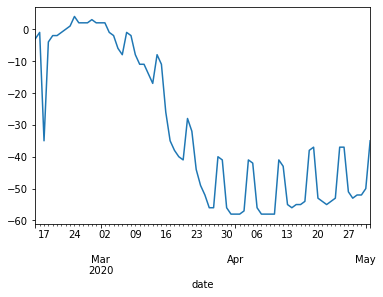

In [12]:
washington_dataset.mobility_workplaces.plot()

Modelling

In [13]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [14]:
train_dataset = washington_dataset[:4 * len(washington_dataset) //5]
test_dataset = washington_dataset[4 * len(washington_dataset) //5:]
scaler = RobustScaler()
target_column = ['new_cases']
feature_columns = ['mobility_retail_recreation',
       'mobility_grocery_pharmacy', 'mobility_parks',
       'mobility_transit_stations', 'mobility_workplaces',
       'mobility_residential']
relevant_columns  =target_column + feature_columns
train = pd.DataFrame(scaler.fit_transform(train_dataset[relevant_columns]), columns=relevant_columns)
test = pd.DataFrame(scaler.transform(test_dataset[relevant_columns]), columns=relevant_columns)

In [15]:
def create_sequences(data, seq_length, feature_columns, target_columns):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)][feature_columns].values
        y = data.iloc[i+seq_length][target_columns].values
        xs.append(x)
        ys.append(y)

    return torch.tensor(xs).float().cuda(), torch.tensor(ys).float().cuda()

In [ ]:
def predict_multi(model, time_steps, data, start_rows, target_feature_index):
    """
    start_rows:np.array of dimension ()
    """
    with torch.no_grad():
        predictions = []
        for i in range(time_steps):
            prediction = model(torch.tensor(data[:start_rows]))
            prediction = torch.flatten(prediction).item()
            predictions.append(prediction)
            data[start_rows + 1, target_feature_index] = prediction
            start_rows = start_rows+1
        
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
  start_rows=np.expand_dims(start_rows, axis=0)
  trg = np.expand_dims(trg, axis=0)
  print(start_rows)
  print(start_rows.shape)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    if trg and known_colums_indices:
      for target in known_colums_indices:
        out[:, :, target] = trg[:, i, target]
      targ[:, i, :]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]

In [15]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, n_features, n_hidden=128, seq_len=5, n_layers=2, dropout=0.2):
        super().__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout,
#             bidirectional=True
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).cuda(),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).cuda()
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [16]:
def train_model(model, X_train, y_train, X_test=None, y_test=None, lr=1e-3,  num_epochs = 20):
    loss_function = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_hist = torch.zeros(num_epochs)
    test_hist = torch.zeros(num_epochs)
    
    for i in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_function(y_pred.float(), y_train)
        train_hist[i] = loss.item()
        if X_test is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_function(y_test_pred.float(), y_test)
                test_hist[i] = test_loss.item()
            if i % 10 == 0:  
                print(f'Epoch {i} train loss: {loss.item()} test loss: {test_loss.item()}')
        else:
            if i % 10 == 0:  
                print(f'Epoch {i} train loss: {loss.item()} ')
        
        optimiser.zero_grad()

        loss.backward()

        optimiser.step()
        
    return model.eval(), train_hist, test_hist

    

In [21]:
SEQ_LEN = 10
N_LAYERS=4
N_HIDDEN=128
NUM_EPOCHS=15
X_train, y_train = create_sequences(train,seq_length=SEQ_LEN, feature_columns=relevant_columns, target_columns=['new_cases'])
X_test, y_test =  create_sequences(test,seq_length=SEQ_LEN, feature_columns=relevant_columns, target_columns=['new_cases'])
model = TimeSeriesLSTM(
  n_features=train.shape[1], 
  n_hidden=N_HIDDEN, 
  seq_len=SEQ_LEN, 
  n_layers=N_LAYERS,
)
model = model.cuda()
print(next(model.parameters()).is_cuda, X_train.device, y_train.device)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=NUM_EPOCHS)


True cuda:0 cuda:0
Epoch 0 train loss: 1.4428982734680176 test loss: 0.549592912197113
Epoch 10 train loss: 1.229490041732788 test loss: 0.3068544566631317


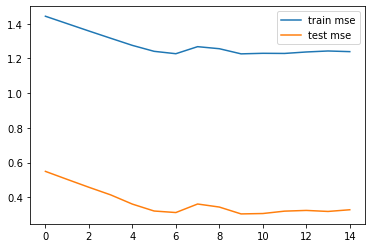

In [25]:
plt.plot(train_hist.numpy(), label='train mse')
plt.plot(test_hist.numpy(), label='test mse')
plt.legend()